# **Physics-based loss and machine learing approach in application to fluids flow modelling: 3D flow in a pipe**
It is supposed that the Newtonian fluid flows through a cylindrical pipe with radius $R$. The flow is steady, the Reynolds number is smaller than the critical one $Re < Re^* {\approx} 1100...1400$ and the pipe length is greater than the critical one $L_3 > 0.16RRe$. 



# Initialization
## Import libraries

In [230]:
# Pytorch modules
import torch
from torch import nn

# Plotting
from matplotlib import pyplot as plt
from matplotlib import transforms
import numpy as np

# Python functions
from collections import namedtuple
from itertools import product
from collections import OrderedDict
#from scipy import integrate

# Status bar
from tqdm.notebook import tqdm
from datetime import datetime
import time

# Work with files and images
import json
from pathlib import Path
import os, fnmatch
import re
from PIL import Image

#Log
import neptune.new as neptune
from neptune.new.types import File

import time

## Neptune project

In [2]:
run = neptune.init(
    project="avkornaev/PhysicsBasedDL",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRjMGY4Ny1hYTI1LTQxZmEtYjRmZC02YzNkYWZjYzNiNjIifQ==",
)  # your credentials

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: NeptuneDeprecationWarning: `init` is deprecated, use `init_run` instead. We'll end support of it in `neptune-client==1.0.0`.
  This is separate from the ipykernel package so we can avoid doing imports until


https://app.neptune.ai/avkornaev/PhysicsBasedDL/e/PHYSIC-80
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Download and preprocess image of the flow domain

## Path

In [276]:
path =  Path('/root/Physics_based_loss')
imgPath = path/'ToyDataset'
imgList = fnmatch.filter(os.listdir(imgPath), '*.pt') #imgPath.ls()
imgList
#Image number from the imgList
imgNo = 0
print(imgList, imgNo)

['pipe_tensor.pt'] 0


Download 3D image

In [277]:
img = torch.load(os.path.join(imgPath, imgList[imgNo]))
imgDim = img.shape[1:]
print(f'image shape: {imgDim}')

image shape: torch.Size([256, 256, 256])


## Constants

In [278]:
#Training
EPOCHS = 1000
NoOfFeatures = 32 #32
WORK_DIR = '/root/Physics_based_loss'
#SCALE_FACTOR = 1 # muliplier for the loss function
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "unet"
EARLY_STOP_PATIENCE = EPOCHS
DECAY = 1e-4
PATIENCE = 0

parameters = {'image_size':SIZE,
             'Epochs':EPOCHS,
             'Model':MODEL_NAME,
             'No_of_features':NoOfFeatures}

HYPS = []

hyps = {"Epochs":[EPOCHS],
        "learning_rate": [1e-3],
        "scheduler": ["none"],
        "scheduler_factor": [0.1],
        "scheduler_patience": [50],
        "use_bn": [True],
        "Early_stop_patience": [EARLY_STOP_PATIENCE],
        "Decay": [DECAY]} # Use or not batchnorm
    
for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})
#"scheduler": ["None", "step", "cycle"]
#"use_bn": [True, False]

#Visualization
slices = [int(imgDim[0]/2), int(imgDim[1]/2), int(imgDim[2]/2)]
vps = 10 #vector plot step 
FIGSIZE = 5 # figure size

## Log parameters

In [5]:
run["config/parameters"] = parameters
run["config/hyperparameters"] = hyps

/opt/conda/lib/python3.7/site-packages/neptune/new/attributes/attribute.py:64: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  return self.assign(value, wait)


## Geometry of the flow domain, fluid properties and boundary conditions

Geometry

It is convenient to present the flow domain $\Omega$ in the form of a parallelepiped $x_i^- < x_i < x_i^+$, $(\boldsymbol{L} = [l_i] = [x_i^+ - x_i^-])$.

In [279]:
# L_1 x L_2 x L_3 flow domain
L = [0.012, 0.012, 0.5]#, [m]
R = L[0]/2 #, [m]

# Normalized coordinates, finite diferences, limits and elementary surface area
X1N = torch.linspace(0, 1, SIZE)
X2N = torch.linspace(0, 1, SIZE)
X3N = torch.linspace(0, 1, SIZE)

DX1N = X1N[1] - X1N[0]
DX2N = X2N[1] - X2N[0]
DX3N = X3N[1] - X3N[0]

LIM1 = [0, L[0]]
LIM2 = [0, L[1]]
LIM3 = [0, L[2]]

#dOmega = DX1N * DX2N * DX3N * DELTAX1 * DELTAX2 * DELTAX3 # elementary volume

Boundary conditions: flow rates [$m^3/s$] through the edges $S_i^+$ ($i = 1,2,3$) of the flow domain $\Omega$, and number of the boundary layers with the fixed values of the unknown function $\boldsymbol\Psi$.

In [194]:
#Flow rates Q1,Q2,Q3
Q = [0, 0, 2E-5]

#Number of layers with fixed values of the unknown Psi function
NL = 5

Properties of non-Newtonian fluid and walls that are relatively rigid body.
The Herschel-Bulkley law is applied:
\begin{equation}
    \mu(H)=q_0+q_1H^{z-1},
\end{equation}
where $q_0$, $q_1$, $z$ are the parameters obtained from rheological tests.

In [195]:
#Non-Newtonian fluid viscosity
Q0 = 1e-3
Q1 = 0
Z = 1
# Fluid density, kg/m**3
RHO = 1000
#Newtonian fluid analogue
MU = 1e-2

#Critical Reynolds number
Re_cr = 1100

#Walls viscosity
Q0W = 1e+3#1e-0#1e+3eye 
Q1W = 0#1e-0
ZW =1#0.5

## Additional functions

Numerical derivative

In [196]:
def num_diff(f,dx1,dx2,dx3,template='fc'):
    '''The following templates are applied:
    sc - second-order central difference,
    fc - fifth-order central difference.
    Indexing:
    i - index along x_1,
    j - index along x_2,
    k - index along x_3.
    '''
    #Shape
    n1, n2, n3 = f.shape
    print(f.shape)
    df_dx1, df_dx2, df_dx3 = torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3)
    
    #Device
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
        df_dx3 = df_dx3.to('cuda')
    
    #Derivatives
    if template == 'sc':
        # x1 derivative:
        df_dx1[1:n1-1,:,:] = (f[2:,:,:] - f[:-2,:,:]) / (2 * dx1)
        df_dx1[0,:,:] = (-f[2,:,:] + 4 * f[1,:,:] - 3 * f[0,:,:]) / (2 * dx1)
        df_dx1[n1-1,:,:] = (3 * f[n1-1,:,:] - 4 * f[n1-2,:,:] + f[n1-3,:,:]) / (2 * dx1)
        # x2 derivative:
        df_dx2[:,1:n2-1, :] = (f[:, 2:, :] - f[:, :-2, :]) / (2 * dx2)
        df_dx2[:,0, :] = (- f[:,2,:] + 4 * f[:,1,:] - 3 * f[:, 0, :]) / (2 * dx2)
        df_dx2[:,n2-1, :] = (3 * f[:, n2 - 1, :] - 4 * f[:, n2 - 2, :] + f[:, n2 - 3, :]) / (2 * dx2)
        # x3 derivative:
        df_dx3[:, :, 1:n3-1] = (f[:,:,2:] - f[:,:,:-2]) / (2 * dx3)
        df_dx3[:, :, 0] = (- f[:, :, 2] + 4 * f[:, :, 1] - 3 * f[:, :, 0]) / (2 * dx3)
        df_dx3[:, :, n3-1] = (3 * f[:, :, n3 - 1] - 4 * f[:, :, n3 - 2] + f[:, :, n3 - 3]) / (2 * dx3)
    elif template == 'fc':
        # x1 derivative
        df_dx1[2:n1-2, :, :] = (-f[4:, :,:] + 8 * f[3:n1-1, :, :] - 8 * f[1:n1-3, :, :] + f[:n1-4, :, :]) / (12 * dx1)
        df_dx1[0, :, :] = (-3 * f[4, :, :] + 16 * f[3, :, :] - 36 * f[2, :, :] + 48 * f[1, :,:] - 25 * f[0, :, :]) / (12 * dx1)
        df_dx1[1, :, :] = (f[4, :, :] - 6 * f[3, :, :] + 18 * f[2, :, :] - 10 * f[1, :, :] - 3 * f[0, :, :]) / (12 * dx1)
        df_dx1[n1-2, :, :] = (3 * f[n1-1, :, :] + 10 * f[n1-2, :, :] - 18 * f[n1-3, :, :] + 6 * f[n1-4, :, :] - f[n1-5, :, :]) / (12 * dx1)
        df_dx1[n1-1, :, :] = (25 * f[n1-1, :, :] - 48 * f[n1-2, :, :] + 36 * f[n1-3, :, :] - 16 * f[n1-4, :, :] + 3*f[n1-5, :, :]) / (12 * dx1)
        
        # x2 derivative
        df_dx2[:, 2:n2-2, :] = (-f[:, 4:, :] + 8 * f[:, 3:n2-1, :] - 8 * f[:, 1:n2-3, :] + f[:, :n2-4, :]) / (12 * dx2)
        df_dx2[:, 0, :] = (-3 * f[:,4, :] + 16 * f[:, 3, :] - 36 * f[:, 2, :] + 48 * f[:, 1, :] - 25 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, 1, :] = (f[:, 4, :] - 6 * f[:, 3, :] + 18 * f[:, 2, :] - 10 * f[:, 1, :] - 3 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, n2-2, :] = (3 * f[:, n2-1, :] + 10 * f[:, n2-2, :] - 18 * f[:, n2-3, :] + 6 * f[:, n2-4, :] - f[:, n2-5, :]) / (12*dx2)
        df_dx2[:, n2-1, :] = (25 * f[:, n2-1, :] - 48 * f[:, n2-2, :] + 36 * f[:, n2-3, :] - 16 * f[:, n2-4, :] + 3 * f[:,n2-5, :]) / (12*dx2)       
        # x3 derivative
        df_dx3[:, :, 2:n3-2] = (-f[:, :, 4:] + 8 * f[:, :, 3:n3-1] - 8 * f[:, :, 1:n3-3] + f[:, :, :n3-4]) / (12 * dx3)
        df_dx3[:, :, 0] = (-3 * f[:, :, 4] + 16 * f[:, :, 3] - 36 * f[:, :, 2] + 48 * f[:, :, 1] - 25 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, 1] = (f[:, :, 4] - 6 * f[:, :, 3] + 18 * f[:, :, 2] - 10 * f[:, :, 1] - 3 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, n3-2] = (3 * f[:, :, n3-1] + 10 * f[:, :, n3-2] - 18 * f[:, :, n3-3] + 6 * f[:,:,n3-4] - f[:, :, n3-5]) / (12 * dx3)
        df_dx3[:, :, n3-1] = (25 * f[:,:, n3-1] - 48 * f[:,:, n3-2] + 36 * f[:,:, n3-3] - 16 * f[:,:, n3-4] + 3*f[:,:, n3-5]) / (12 * dx3)
    
    return df_dx1, df_dx2, df_dx3

Check diff

In [197]:
# x1 = torch.linspace(1, 2, 5)
# x2 = torch.linspace(1, 2, 5)
# x3 = torch.linspace(1, 2, 5)

# dx = x[1]-x[0]
# x1,x2,x3 = torch.meshgrid(x1,x2,x3)

# v = (x1**2+ x2**3 + x3**4)

# gradv = num_diff(v,dx,dx,dx,template='fc')
# gradv

Visualization

In [198]:
def vector_plot(arg, vec, FIGSIZE, vptitle='vector_plot',step=10):
    gradmag = np.sqrt(vec[0]**2+vec[1]**2)
    plt.pcolor(arg[0], arg[1], gradmag, cmap='rainbow')
    plt.colorbar()
    plt.quiver(arg[0][::step,::step], arg[1][::step,::step], vec[0][::step,::step], vec[1][::step,::step])
    plt.title(vptitle)
 

## Major functions

For any given function $\boldsymbol\Psi = [\psi_i]$ that has fixed values on the boundaries of the flow domain together with its first, second, and third derivatives, the velocity distribution can be expressed in compact or in expanded form, respectively:
\begin{equation} 
    \boldsymbol{V} = \epsilon_{ijk}
    \begin{bmatrix}
    \frac{\partial \psi_k(x_i,x_j)}{\partial x_j}
    \end{bmatrix},
\end{equation}
where $\epsilon_{ijk}$ is the Levi-Civita symbol,

\begin{equation} 
    \boldsymbol{V} = 
    \begin{bmatrix}
    \frac{\partial \psi_3}{\partial x_2} - \frac{\partial \psi_2}{\partial x_3}, &
    \frac{\partial \psi_1}{\partial x_3} - \frac{\partial \psi_3}{\partial x_1}, &
    \frac{\partial \psi_2}{\partial x_1} - \frac{\partial \psi_1}{\partial x_2}
    \end{bmatrix}.
\end{equation} 

In [199]:
def velocityDistr(psi1,psi2,psi3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    '''Velocity distribution [v_i] in the flow domain
    '''
#     v1 = 0
#     v2 = 0
#     v3 = 0
    
#     dpsi1dx1 = 0
#     dpsi1dx2 = 0
#     dpsi1dx3 = 0
    
#     dpsi2dx1 = 0
#     dpsi2dx2 = 0
#     dpsi2dx3 = 0
    
#     dpsi3dx1 = 0
#     dpsi3dx2 = 0
#     dpsi3dx3 = 0
           
    dpsi1dx1, dpsi1dx2, dpsi1dx3 = num_diff(psi1, dx1n, dx2n, dx3n)
    dpsi2dx1, dpsi2dx2, dpsi2dx3 = num_diff(psi2, dx1n, dx2n, dx3n)
    dpsi3dx1, dpsi3dx2, dpsi3dx3 = num_diff(psi3, dx1n, dx2n, dx3n)
    
    v1 = (dpsi3dx2 / deltax2) - (dpsi2dx3 / deltax3)
    v2 = (dpsi1dx3 / deltax3) - (dpsi3dx1 / deltax1)
    v3 = (dpsi2dx1 / deltax1) - (dpsi1dx2 / deltax2)
    
    return v1, v2, v3

Taking into account the symmetry of the shear rate tensor $\xi_{i,j}=\xi_{i,j}$, the tensor has the following form:

\begin{equation}
    \boldsymbol{T}_\xi= \frac{1}{2}   
    \begin{bmatrix}
    2\frac{\partial v_1}{\partial x_1}, & \frac{\partial v_1}{\partial x_2} - \frac{\partial v_2}{\partial x_1}, & \frac{\partial v_1}{\partial x_3} - \frac{\partial v_3}{\partial x_1} \\
     \frac{\partial v_1}{\partial x_2} - \frac{\partial v_2}{\partial x_1}, & 2\frac{\partial v_2}{\partial x_2}, & \frac{\partial v_2}{\partial x_3} - \frac{\partial v_3}{\partial x_2}  \\
    \frac{\partial v_1}{\partial x_3} - \frac{\partial v_3}{\partial x_1}, & \frac{\partial v_2}{\partial x_3} - \frac{\partial v_3}{\partial x_2},  & 2\frac{\partial v_3}{\partial x_3}  \\
    \end{bmatrix}.
\end{equation}

In the general case of a three dimensional flow the shear strain rate intensity $H$ depends on all the components of the shear rate tensor:
\begin{equation}
    H =\sqrt{2(\xi_{11}^2 + \xi_{22}^2 + \xi_{33}^2 + 2\xi_{12}^2 + 2\xi_{13}^2 + 2\xi_{23}^2)}. 
\end{equation}

In [200]:
def TksiDistr(v1,v2,v3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    '''Strain rate tensor Txi and the shear rate intensity Eta squared
    '''    
#     xi11 = 0
#     xi12 = 0
#     xi13 = 0
    
#     xi22 = 0
#     xi23 = 0
    
#     xi33 = 0
    
#     dv1dx1 = 0
#     dv1dx2 = 0
#     dv1dx3 = 0
    
#     dv2dx1 = 0
#     dv2dx2 = 0
#     dv2dx3 = 0
    
#     dv3dx1 = 0
#     dv3dx2 = 0
#     dv3dx3 = 0
    
    dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
    dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
    dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
    
    #Txi
    xi11 = dv1dx1 / deltax1
    xi12 = 0.5 * ((dv1dx2 / deltax2) + (dv2dx1 / deltax1))
    xi13 = 0.5 * ((dv1dx3 / deltax3) + (dv3dx1 / deltax1))
    
    xi22 = dv2dx2 / deltax2
    xi23 = 0.5 * ((dv2dx3 / deltax3) + (dv3dx2 / deltax2))
    
    xi33 = dv3dx3 / deltax3
    
    #Eta^2    
    EtaEta = (2 * (xi11 * xi11 + xi22 * xi22 + xi33 * xi33 + 
                   2 * (xi12 * xi12 + xi13 * xi13 + xi23 * xi23)))
  
    return xi11, xi12, xi22, EtaEta

## Callbacks

In [201]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

## Training function

In [202]:
def train(model, inp, optimizer,
          criterion, epochs, print_every, callbacks, lr_scheduler):
    """Make model prediction on image.
    
    Args:
        model (Model): Model for training.
        inp (Tensor): Inpu image.
        optimizer (Optimizer): Optimizer. 
        criterion (callable): Function for loss calculation.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks
    
    Returns:
        history (dict): Dict of lists with train history.
    """
    
    history = {'Train loss':[]}
    
    if callbacks:
        for i in callbacks:
            i.start(history, model)
    
    train_print = ''
    state_text_last = ''
    bar = tqdm(range(epochs), desc="Epoch", postfix=train_print)
    for e in range(epochs):
        model.train()

        running_loss = 0

        stop = False
        
        steps = 0
        
        optimizer.zero_grad()
        
        out = model.forward(inp)
            
        loss = criterion(out)
        if e > PATIENCE:
            run["training/batch/loss_training"].log(loss)

        loss.backward()
                
        optimizer.step()
            
        with torch.no_grad():
            running_loss = loss.item()
        
        if (e + 1) % print_every == 0:
            print(f'epoch {e+1}/{epochs}, loss = {running_loss:.4f}')
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            model.train()
            
        
        history['Train loss'].append(running_loss)
        
        if lr_scheduler:
            if "OneCycleLR" in str(lr_scheduler):
                lr_scheduler.step()
            else:
                lr_scheduler.step(running_loss)
        
        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text:
                    state_text_last = state_text
                if state:
                    stop = True
        if stop:
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            inputs = None
            targets = None
            outputs = None
            loss = None
            sm = None
            
            torch.cuda.empty_cache()
            
            break
            
        if e + 1 != epochs:
            bar.update()
                        
        inputs = None
        targets = None
        outputs = None
        loss = None
        sm = None
        
        torch.cuda.empty_cache()
      
    bar.update()
    bar.close()
    
    if callbacks:
        for i in callbacks:
            i.stop()
    
    model = None
    
    torch.cuda.empty_cache()
    
    return history


def plot_train_history(history):
    """Plot train history.
    
    Args:
        history (dict): Dict of lists with train history..
    """
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train loss'], c = 'r')
    ax.set_title('Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
    ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()

    
def dict2str(dict1):
    out = str(dict1).replace("}", "")
    out = str(out).replace("{", "")
    out = str(out).replace("\"", "")
    out = str(out).replace("\'", "")
    out = str(out).replace(":", "")
    return out

# Analitical solution in case if the fluid is Newtonian

The task of fluid flow through a pipe is known as Poiseuille flow and it has a simple analytical solution given in **cylindrical coordinates** $[\rho, \theta, x_3]$:

\begin{equation}
    {v_3} = - \frac{1}{4\mu}\frac{\partial p}{\partial x_3}(R^2 - \rho^2),
\end{equation}
where ${\partial p}/{\partial x_3}$ is the pressure drop along the axis of the cylinder.

The flow rate trough the pipe cross section (surface $S_3$) is equal to:

\begin{equation}
    {Q_3} = \iint_{S_3} v_3 \rho\,d\rho\,d\theta =  - \frac{\pi}{8}\frac{\partial p}{\partial x_3}\frac{R^4}{\mu}.
\end{equation}

Given data

In [203]:
print(f'fluid viscosity: mu = {MU},')
print(f'flow rate along x_3 axis: Q3 = {Q[2]}.')

fluid viscosity: mu = 0.01,
flow rate along x_3 axis: Q3 = 2e-05.


Simulation results

In [204]:
dpdx3a = - Q[2]*8*MU/(np.pi*(R**4))
v3amax = -1/(4*MU)*dpdx3a*(R**2)

Re = RHO*v3amax*2*R/MU
Lcr = 0.16*R*Re

#v3a = -1/(4*mu)*dpdx_3*(R**2 - x_1**2 - x_2**2)

print(f'pressure drop along x_3 axis: dpdx3 = {dpdx3},')
print(f'maximum velocity: v3 = {v3amax},')
print(f'Reynolds number Re = {Re} is smaller than critical Re < {Re_cr}: {Re<Re_cr}')
print(f'Pipe length L_3 = {L[2]} is longer than critical L_cr = {Lcr}: {L[2]>Lcr}')


pressure drop along x_3 axis: dpdx3 = -982.4379203203415,
maximum velocity: v3 = 0.35367765131532297,
Reynolds number Re = 424.41318157838754 is smaller than critical Re < 1100: True
Pipe length L_3 = 0.5 is longer than critical L_cr = 0.40743665431525206: True


# Machine learning solution
## Flow domain visualization

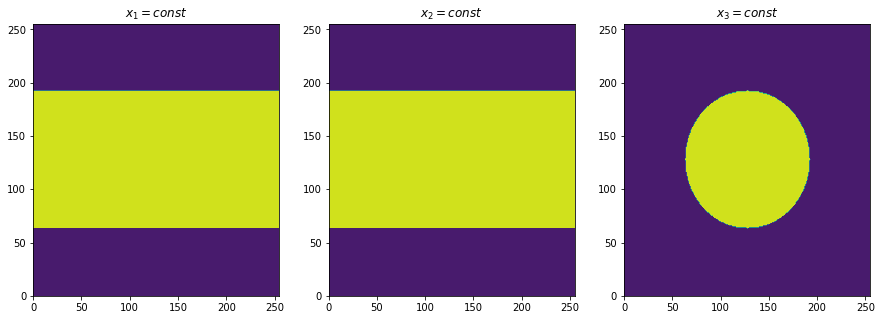

In [289]:
nr=1
nc=3

plt.figure(figsize=(nc*FIGSIZE,nr*FIGSIZE))

plt.subplot(nr,nc,1)
plt.contourf(img[0,slices[0],:,:])
plt.title('$x_1 = const$')

plt.subplot(nr,nc,2)
plt.contourf(img[0,:,slices[1],:])
plt.title('$x_2 = const$')

plt.subplot(nr,nc,3)
plt.contourf(img[0,:,:,slices[2]])
plt.title('$x_3 = const$')

plt.show()

In [287]:
img.min(),img.max()

(tensor(0.), tensor(1.))

## Kinematic properties
The flow rate through a cross-section $x_i = const$ can be expressed as follows:

\begin{equation} 
    \label{eq:flowRate}
    Q_i(x_i) = -\epsilon_{ijk}(\psi_j(x_i,x_k^+) - \psi_j(x_i,x_k^-))l_j,
\end{equation}
where $l_j = (x_j^+ - x_j^-)$.

The flow rates $Q_i$ through the edges $S_i^+$ when $x_i = x_i^+$ are given.

It is convenient to suppose that $\psi_j(x_i,x_k^-) = 0$, then the flow rates througth the edges $S_i^+$ are:

\begin{equation}
    \begin{matrix}
    Q_1 = Q_1(x_1^+) = - \psi_2(x_1^+,x_3^+)l_2 + \psi_3(x_1^+,x_2^+)l_3, & \\
    Q_2 = Q_2(x_2^+) = - \psi_3(x_1^+,x_2^+)l_3 + \psi_1(x_2^+,x_3^+)l_1, & \\
    Q_3 = Q_3(x_3^+) = - \psi_1(x_2^+,x_3^+)l_1 + \psi_2(x_1^+,x_3^+)l_2.
    \end{matrix}
\end{equation}


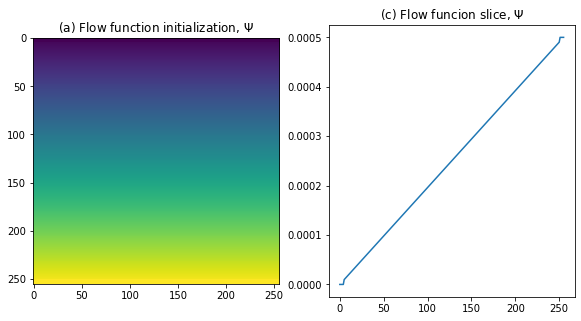

tensor(1.0000e-05) tensor(-1.0000e-05) tensor(1.0000e-05)
Q1 = 1.9999999494757503e-05
Q2 = 0.0
Q3 = -1.9999999494757503e-05


In [297]:
#Initialization
psi1 = (torch.linspace(0, -Q[2]/2, imgDim[1], dtype=torch.float32) * torch.ones(imgDim[1],imgDim[2])).T
psi2 = (torch.linspace(0,  Q[2]/2, imgDim[0], dtype=torch.float32) * torch.ones(imgDim[0],imgDim[2])).T
psi3 = (torch.linspace(0,  Q[2]/2, imgDim[0], dtype=torch.float32) * torch.ones(imgDim[0],imgDim[1])).T

# Fix constant values in NL first and last layers and set the boundary conditions (set flow rates)
psi1[:NL,:] = 0
psi1[-NL:,:] = - Q[2]/2

psi2[:NL,:] = 0
psi2[-NL:,:] = Q[2]/2

psi3[:NL,:] = 0
psi3[-NL:,:] = Q[2]/2

#Visualization

fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
plt.subplot(nr,nc,1)
plt.imshow(psi0)
plt.title('(a) Flow function initialization, $\Psi$')

plt.subplot(nr,nc,2)
plt.plot(psi0[:,sp])
plt.title('(c) Flow funcion slice, $\Psi$')

plt.show()

#Check flow rates
print(psi1[-1,-1], psi2[-1,-1], psi3[-1,-1])
print(f'Q1 = {- psi2[-1,-1] + psi3[-1,-1]}')
print(f'Q2 = {- psi3[-1,-1] + psi1[-1,-1]}')
print(f'Q3 = {- psi1[-1,-1] + psi2[-1,-1]}')

## Create model
Unet architecture [2] is used

In [27]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=4, use_bn=True):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1", use_bn=use_bn)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2", use_bn=use_bn)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3", use_bn=use_bn)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4", use_bn=use_bn)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck", use_bn=use_bn)

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4", use_bn=use_bn)
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3", use_bn=use_bn)
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2", use_bn=use_bn)
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1", use_bn=use_bn)
        self.decoder0 = UNet._block(features, features, name="dec1", use_bn=use_bn)
        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec0 = self.decoder0(dec1)
        return torch.sigmoid(self.conv(dec0))*Q

    @staticmethod
    def _block(in_channels, features, name, use_bn):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm1", nn.BatchNorm2d(num_features=features)),
                      (name + "relu1", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm2", nn.BatchNorm2d(num_features=features)),
                      (name + "relu2", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                ]
            )
        )
    
def power_loss(psi):
    
    #Fix psi function on the boundaries
    psi[:,:,:NL,:] = 0
    psi[:,:,-NL:,:] = Q
    psi_masked = psi[0,0,:,:]
    
    #psi_masked = (psi[0,0,:,:] * flowDomainMask) + (lowerWallMask * Q)
    v1,v2 = velocityDistr(psi_masked, DX1N, DX2N, LIM1, LIM2)
    
    xi11, xi12, xi22, EtaEta = TksiDistr(v1, v2, DX1N, DX2N, LIM1, LIM2)
    
    #Subintegral expression with masks for fluid and walls, respectively:
    subInt = ((0.5*Q0*EtaEta + ((Q1/(Z+1))*EtaEta**((Z+1)*0.5)))*flowDomainMask + 
              (0.5*Q0W*EtaEta + ((Q1W/(ZW+1))*EtaEta**((ZW+1)*0.5)))*(1-flowDomainMask)) 
    
    int1EtaEta = torch.trapz(subInt)# + v1*Fm[0]+v2*Fm[1])
    int2EtaEta = torch.trapz(int1EtaEta)
    
    #int2EtaEta = int_func_sympson_2d(EtaEta + v1*Fm[0]+v2*Fm[1], DX1N, DX2N)
  
    out = int2EtaEta*s #doublelIntegral(0.5*mu*EtaEta,lim1,lim2) #loss
    
    return out #0.5 * MU * s * EtaEta.mean()

## Training

In [28]:
start_time = time.time()

hyperparams: 
 Epochs 60000, learning_rate 0.001, scheduler none, scheduler_factor 0.1, scheduler_patience 50, use_bn True, Early_stop_patience 60000, Decay 0.0001


Epoch:   0%|          | 0/60000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 100/60000, loss = 23455.3359
epoch 200/60000, loss = 9618.0742
epoch 300/60000, loss = 4346.7861
epoch 400/60000, loss = 2575.3889
epoch 500/60000, loss = 1819.8722
epoch 600/60000, loss = 1426.5226
epoch 700/60000, loss = 1186.0066
epoch 800/60000, loss = 1022.6808
epoch 900/60000, loss = 901.1129
epoch 1000/60000, loss = 806.8507
epoch 1100/60000, loss = 732.6370
epoch 1200/60000, loss = 671.7179
epoch 1300/60000, loss = 621.7708
epoch 1400/60000, loss = 578.6423
epoch 1500/60000, loss = 539.3271
epoch 1600/60000, loss = 505.2104
epoch 1700/60000, loss = 475.2498
epoch 1800/60000, loss = 448.3486
epoch 1900/60000, loss = 424.6942
epoch 2000/60000, loss = 403.9341
epoch 2100/60000, loss = 384.7180
epoch 2200/60000, loss = 366.8172
epoch 2300/60000, loss = 350.9874
epoch 2400/60000, loss = 335.3944
epoch 2500/60000, loss = 320.5497
epoch 2600/60000, loss = 314.1321
epoch 2700/60000, loss = 295.4453
epoch 2800/60000, loss = 284.9765
epoch 2900/60000, loss = 273.6265
epoch 3000/600

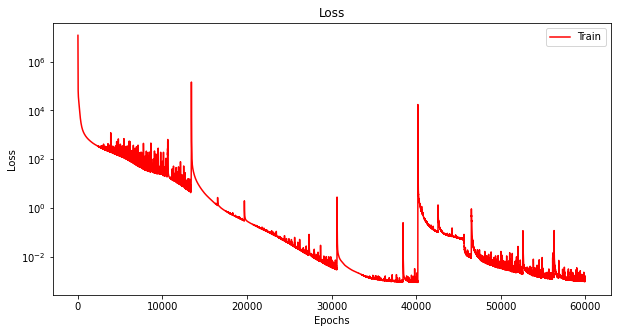

Final loss: 0.001
simulation time:138m 24s


In [29]:
os.makedirs(WORK_DIR + '/models', exist_ok=True)
os.makedirs(WORK_DIR + '/history', exist_ok=True)

x = torch.ones((1, 1, SIZE, SIZE)) * psi0_masked
s = DX1N * DX2N * LIM1[1] * LIM2[1]

# Перемещение на GPU
x = x.to(DEVICE)
flowDomainMask = flowDomainMask.to(DEVICE)
#lowerWallMask = lowerWallMask.to(DEVICE)
DX1N = DX1N.to(DEVICE)
DX2N = DX2N.to(DEVICE)
s = s.to(DEVICE)

run_record = {}

for hyp in HYPS:
    print('hyperparams: \n', dict2str(hyp)) 

    model_path = (f'{WORK_DIR}/models/{MODEL_NAME}_{dict2str(hyp)}.pth')

    callbacks = [SaveBest(f'Train loss', model_path, 'min'),
                 EarlyStop(f'Train loss', EARLY_STOP_PATIENCE, 'min')]

    model = UNet(in_channels=1, out_channels=1, init_features=NoOfFeatures, use_bn=hyp["use_bn"])
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=hyp["learning_rate"], weight_decay=DECAY)
    
    criterion = power_loss
    
    #Log model, criterion, and optimizer
    run["config/model"] = type(model).__name__
    run["config/criterion"] = type(criterion).__name__
    run["config/optimizer"] = type(optimizer).__name__

    
    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                  patience=hyp["scheduler_patience"],
                                                                  min_lr=1e-6, factor=hyp["scheduler_factor"])
    elif hyp["scheduler"] == "cycle":
        lr_scheduler = scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hyp["learning_rate"] * 20,
                                                                       steps_per_epoch=1, epochs=EPOCHS,
                                                                       pct_start=0.125,
                                                                       div_factor=hyp["scheduler_factor"] ** -1,
                                                                       final_div_factor=(hyp["scheduler_factor"] ** -1) * 50)
    else:
        lr_scheduler = None

    history = train(model, x, optimizer, power_loss,
                    epochs=EPOCHS, print_every=100,
                    callbacks=callbacks, lr_scheduler=lr_scheduler)

    run_record[model_path] = {'hyperparams': hyp,
                              'history': history,
                              'final_val_metric': callbacks[1].best_monitor}

    print(f"Best Train loss %4.4f" % (callbacks[1].best_monitor))

    model = None
    optimizer = None

    torch.cuda.empty_cache()

best_val_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_val_metric is None or best_val_metric > train_info['final_val_metric']:
        best_val_metric = train_info['final_val_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
    json.dump(run_record, fp)

best_hyp = str(best_hyperparams).replace("}", "")
best_hyp = best_hyp.replace("{", "")
best_hyp = best_hyp.replace("'", "")

print(f"Best Train loss: %4.4f, best hyperparams: %s" % (best_val_metric, best_hyp))

model = UNet(in_channels=1, out_channels=1, init_features=NoOfFeatures, use_bn=best_hyperparams["use_bn"])
model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME}_best.pth')

model = model.to(DEVICE)

psi = model.forward(x)

plot_train_history(best_run['history'])

simulation_time = time.time() - start_time
print(f'Final loss: {power_loss(psi).cpu().item() :.3f}')
print('simulation time:{:.0f}m {:.0f}s'.format(
      simulation_time // 60, simulation_time % 60))

## Results

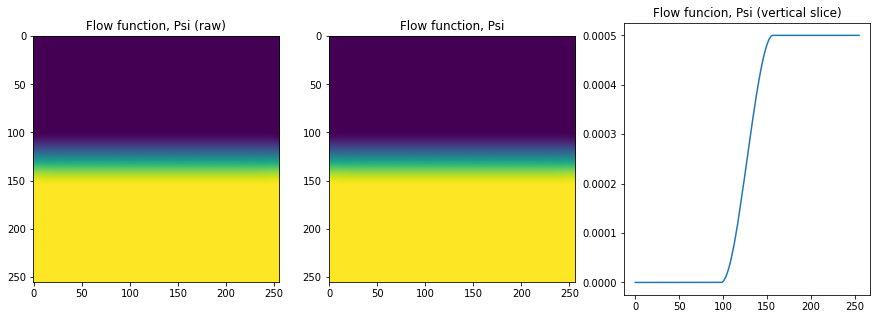

In [30]:
#Output of the network: psi function of the flow

psi_masked = psi[0, 0, :, :].clone().detach() #psi[0, 0, :, :].clone().detach() * flowDomainMask) + (lowerWallMask * Q)
v1, v2 = velocityDistr(psi_masked, DX1N, DX2N, LIM1, LIM2)
xi11ch, xi12ch, xi22ch, EtaEtach = TksiDistr(v1, v2, DX1N, DX2N, LIM1, LIM2)

subInt = ((0.5*Q0*EtaEtach + ((Q1/(Z+1))*EtaEtach**((Z+1)*0.5)))*flowDomainMask + 
              (0.5*Q0W*EtaEtach + ((Q1W/(ZW+1))*EtaEtach**((ZW+1)*0.5)))*(1-flowDomainMask)) 
int1EtaEta = torch.trapz(subInt)
int2EtaEta = torch.trapz(int1EtaEta)
outch = int2EtaEta*s

#Visualization
nr=1
nc=3
fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
plt.subplot(nr,nc,1)
plt.imshow(psi[0, 0, :, :].clone().detach().to('cpu'))
plt.title('Flow function, Psi (raw)')

plt.subplot(nr,nc,2)
plt.imshow(psi_masked.to('cpu'))
plt.title('Flow function, Psi')

plt.subplot(nr,nc,3)
plt.plot(psi_masked[:,sp].to('cpu'))
plt.title('Flow funcion, Psi (vertical slice)')

plt.show()

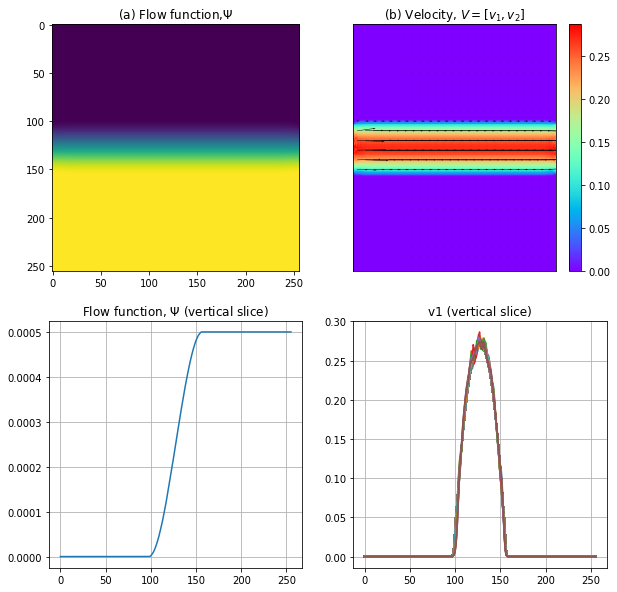

v1_max =  tensor(0.2865, device='cuda:0') v1_min =  tensor(-1.2369e-05, device='cuda:0')


In [31]:
#Visualization
nr=2
nc=2
fig = plt.figure(figsize=(FIGSIZE*nr, FIGSIZE*nc))
plt.subplot(nr,nc,1)
plt.imshow(psi_masked.to('cpu'))
plt.title('(a) Flow function,$\Psi$')

plt.subplot(nr,nc,2)
vector_plot(np.meshgrid(-X1N,-X2N), [np.array(v1.cpu()),np.array(v2.cpu())],FIGSIZE, 
            '(b) Velocity, $V = [v_1, v_2]$', 10)
plt.xticks([])
plt.yticks([])

plt.subplot(nr,nc,3)
plt.plot(psi_masked[:,sp].to('cpu'))
plt.grid(True)
plt.title('Flow function, $\Psi$ (vertical slice)')

plt.subplot(nr,nc,4)
plt.plot(v1.cpu())
plt.grid(True)
plt.title('v1 (vertical slice)')

plt.show()
print('v1_max = ', v1.max(), 'v1_min = ', v1.min())

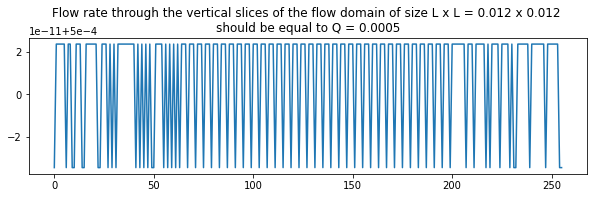

In [32]:
# Check the flow rate
Qch = torch.trapz(v1.t()) * DX1N * L

fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(Qch.cpu())
plt.title(f'Flow rate through the vertical slices of the flow domain of size L x L = {L} x {L} \nshould be equal to Q = {Q}')
plt.show()

In [33]:
print('Q = ', Qch.mean().cpu().item(), '; Loss = ', power_loss(psi).cpu().item())

Q =  0.0004999999655410647 ; Loss =  0.0009041872108355165


In [34]:
print (EtaEta.cpu().min(), EtaEta.cpu().max(), EtaEtach.cpu().min(), EtaEtach.cpu().max()) 
print(outch)


tensor(1.7053) tensor(111117.8516) tensor(0.) tensor(623996.1875)
tensor(0.0009, device='cuda:0')


tensor(1.7053) tensor(111117.8516) tensor(0.) tensor(201881.3438)


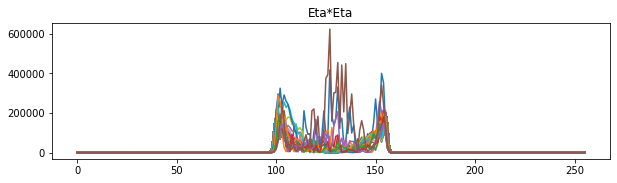

In [35]:

print (EtaEta.cpu().min(), EtaEta.cpu().max(), EtaEtach.cpu()[:,sp].min(), EtaEtach.cpu()[:,sp].max()) 
fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(EtaEtach.cpu())
plt.title('Eta*Eta')
plt.show()

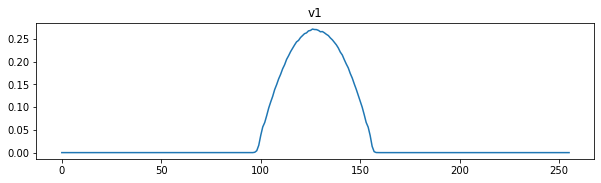

In [36]:
fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(v1.cpu()[:,sp])
plt.title('v1')
plt.show()

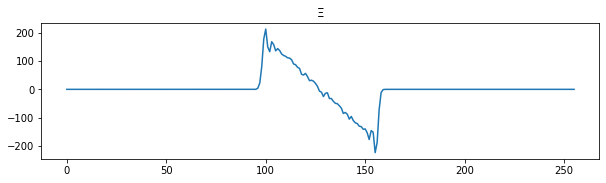

In [37]:
fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(xi12ch.cpu()[:,sp])
plt.title('$\Xi$')
plt.show()


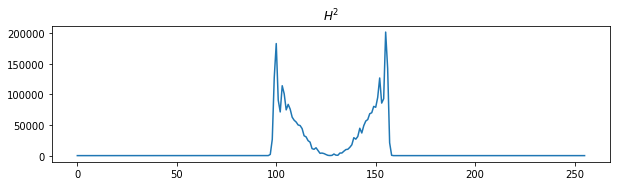

In [38]:
fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(EtaEtach.cpu()[:,sp])
plt.title('$H^2$')
plt.show()

In [39]:
 #Check power
Intch = power_loss(psi).cpu().item()*2
acc_rel_exact = (Int_ex.item()-Intch)/Int_ex.item()*100
Intch, Int_ex.item(), acc_rel_exact

(0.001808374421671033, 0.0013333751121535897, -35.623831972553624)

## Log results

In [40]:
results = {'Internal_power':Intch,
           'Internal_power_exact':Int_ex.item(),
           'Accuracy (in comparison with analitical solution)': acc_rel_exact}
run["config/results"] = results

## Stop logging

In [41]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 38 operations to synchronize with Neptune. Do not kill this process.
All 38 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/avkornaev/PhysicsBasedDL/e/PHYSIC-80


# Links

[1]. https://github.com/Mechanics-Mechatronics-and-Robotics/Mathematical_modelling/blob/main/Practice_1_by_IStebakov.ipynb

[2]. https://github.com/mateuszbuda/brain-segmentation-pytorch